# Several analysers of Model3 on many of Dataset4 images using iNNvestigate

## Different shapes with different radii

This notebook shows how saliency maps are computed for 6 methods supported by the **iNNvestigate** explainability toolbox on a several test images from the Shape Images dataset. 

## Imports

In [1]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

import imp
import numpy as np
from numpy import load
import os.path
import matplotlib.pyplot as plt

import keras.backend as K
if(K.tensorflow_backend):
    import tensorflow as tf
    tf.logging.set_verbosity(tf.logging.ERROR)
from keras.utils import np_utils
from keras.models import load_model

import innvestigate
import innvestigate.utils as iutils
mnistutils = imp.load_source("utils_mnist", "/home/elena/eStep/XAI/Software/innvestigate/examples/utils_mnist.py")
eutils = imp.load_source("utils", "/home/elena/eStep/XAI/Software/innvestigate/examples/utils.py")

from CNNcount import shape_images as si
from CNNcount import model_count_shapes as mcs

Using TensorFlow backend.


## Data
Load the dataset and split to train and test set for the analysis.

The file containing images of different shapes with different radii already exist!
Size of training data:  (42000, 64, 64, 1) and labels:  (42000,)
Size of test data:  (6000, 64, 64, 1) and labels:  (6000,)


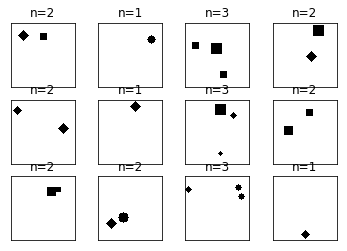

In [2]:
# input image dimensions and number of classes
img_rows, img_cols = 64, 64
num_classes = 3
NMIN, NMAX = 1, 3  # nbr of shapes
RMIN, RMAX = 2, 6  # shape radius
IMGSIZE = 64
OCCL = 0

# filename for loading the data from the NPZ files (NumPy compressed)
dataset = 'diff_shapes_diff_radii'
diff_shapes_diff_radii_fname = "/home/elena/eStep/XAI/Data/CountingShapes/" + dataset + "_60k.npz"


# load the set of images and split to train and test subsets
if os.path.isfile(diff_shapes_diff_radii_fname): # already generated- just load
    print ("The file containing images of different shapes with different radii already exist!")
    # load from NPZ file for display
    images_train, _, images_test, labels_train, _, labels_test = si.load_split_data(diff_shapes_diff_radii_fname)
    
    
    if K.image_data_format() == 'channels_first':
        images_train = images_train.reshape(images_train.shape[0], 1, img_rows, img_cols)
        images_test = images_test.reshape(images_test.shape[0], 1, img_rows, img_cols)

    print("Size of training data: ", np.shape(images_train), "and labels: ", np.shape(labels_train))
    print("Size of test data: ", np.shape(images_test), "and labels: ", np.shape(labels_test))
else: # missing data
    print ("The file containing images of different shapes with different radii does not exist!")
    print("Use the GenerateShapeImages notebook to generate the experimental data.") 
    
# plot random 12 of the train images
si.plot_12images(images_train, labels_train)

## Model
The next part evaluates the pretrained CNN.

In [3]:
# filename for model saving
diff_shape_same_radius_model_fname = "/home/elena/eStep/XAI/Data/CountingShapes/model_diff_shapes_same_radius.h5"
# load the trained model
model = load_model(diff_shape_same_radius_model_fname) 
print("Loaded model from disk")

Loaded model from disk


Formatting of the labels

In [4]:
# convert class vectors to binary class matrices
numerical_labels_test = labels_test
labels_test = np_utils.to_categorical(numerical_labels_test-1, num_classes=None)
print(labels_test)
print('labels_test shape:', labels_test.shape)

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]
labels_test shape: (6000, 3)


Evaluate on test images.

In [5]:
score = model.evaluate(images_test, labels_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.6737834997177123
Test accuracy: 0.7751666666666667


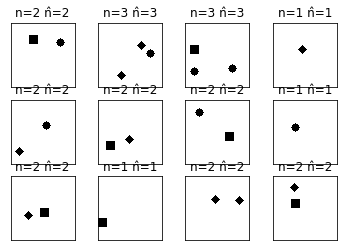

In [6]:
# generate 12 random images and predict the number of shapes using the trained model

num_shapes = len(si.SHAPES)
shape_radius = int((RMIN+RMAX)/2)
for i in range(12):
    n = int(np.random.randint(NMIN, NMAX+1))        
    shapes = [(np.random.randint(num_shapes), shape_radius) for _ in range(n)]
    img = si.generate_image(IMGSIZE, shapes, OCCL)        
    X = img[np.newaxis, :, :, np.newaxis].astype(np.float32)
        
    plt.subplot(3, 4, i+1)
    plt.imshow(img,cmap='binary')
    plt.xticks([])
    plt.yticks([])
        
    predictions = model.predict(X);
    pred = np.argmax(predictions) + 1 # we subtracted 1 before
    plt.title('n=%d n̂=%d' % (n, pred))    


plt.show()

## Analysis

Define a list of top analysis methods by preparing tuples containing the methods' string identifiers used by innvestigate.analyzer.create_analyzer(...), some optional parameters, a post processing choice for visualizing the computed analysis and a title for the figure to render.

In [7]:
# parameters
input_range = [0, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(images_test, input_range)
def input_postprocessing(X):
    #return revert_preprocessing(X) / 255
    return 1-X


noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input

# Configure analysis methods and properties
methods = [
    # NAME            OPT.PARAMS                POSTPROC FXN               TITLE

    # Show input
    ("input",         {},                       input_postprocessing,      "Input"),

    # Signal
    ("pattern.net",   {"pattern_type": "relu"}, mnistutils.bk_proj,        "PatternNet"), 


    # Interaction
    ("pattern.attribution",  {"pattern_type": "relu"}, mnistutils.heatmap,        "PatternAttribution"),
       
    ("deep_taylor.bounded",   {"low": input_range[0],"high": input_range[1]}, mnistutils.heatmap,        "DeepTaylor"),
    
    ("input_t_gradient",     {},                        mnistutils.heatmap,        "Input * Gradient"),
    
    ("integrated_gradients", {"reference_inputs": ri},  mnistutils.heatmap,        "Integrated Gradients"), 

    ("lrp.z",                {},                        mnistutils.heatmap,        "LRP-Z"),
]
    
print('Considered number of explainability methods:', len(methods)-1)

Considered number of explainability methods: 6


The main loop instantiates the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above.

In [8]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

path_to_analyzers = "/home/elena/eStep/XAI/Data/CountingShapes/Analyzers/" + dataset 


# Create analyzers.
analyzers = []
for method in methods:
    fname = os.path.join(path_to_analyzers, method[0]+'.npz')
    
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            neuron_selection_mode="index",
                                            **method[1])     
    
    if os.path.isfile(fname) :
        print("Analyzer", method[0], "exists! Loading...")
        analyzer = analyzer.load_npz(fname)
    else:
        print("Analyzer", method[0], " doesn't exist! Creating and possibly Training and [Saving]...")
        # Some analyzers require training.
        analyzer.fit(images_train, batch_size=256, verbose=1)
        if (method[0]=='pattern.net') or (method[0]=='pattern.attribution'):
            analyzer.save_npz(fname)
    
    analyzers.append(analyzer)


Analyzer input  doesn't exist! Creating and possibly Training and [Saving]...
Analyzer pattern.net exists! Loading...
Analyzer pattern.attribution exists! Loading...
Analyzer deep_taylor.bounded  doesn't exist! Creating and possibly Training and [Saving]...
Analyzer input_t_gradient  doesn't exist! Creating and possibly Training and [Saving]...
Analyzer integrated_gradients  doesn't exist! Creating and possibly Training and [Saving]...
Analyzer lrp.z  doesn't exist! Creating and possibly Training and [Saving]...


Analyze random set of tet images with the different analyzers on all output neurons:

--------------------------------------------------------------------------------
Image nr. 1269; prediction: 3 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

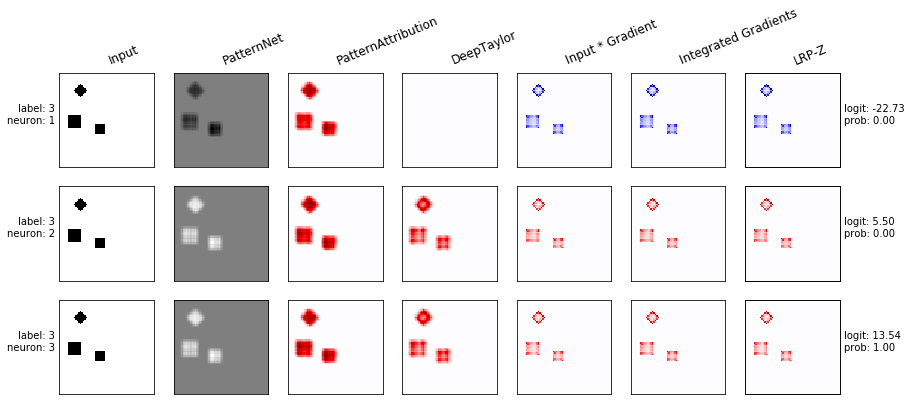

--------------------------------------------------------------------------------
Image nr. 1270; prediction: 2 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

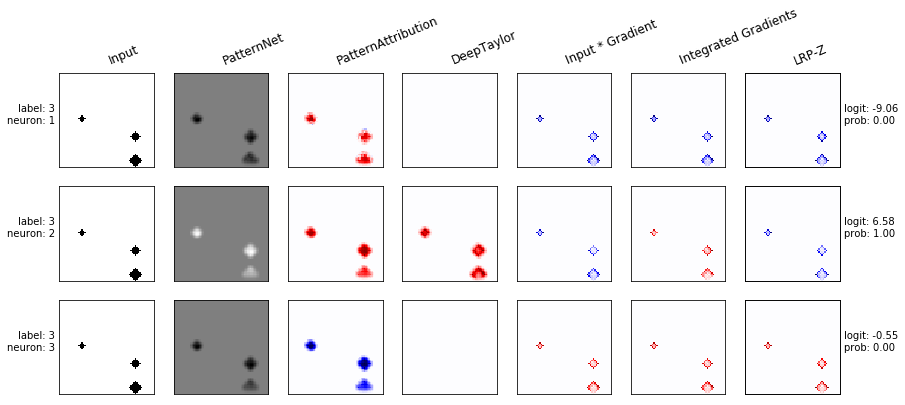

--------------------------------------------------------------------------------
Image nr. 1271; prediction: 1 
('1', '1', '1')


<Figure size 432x288 with 0 Axes>

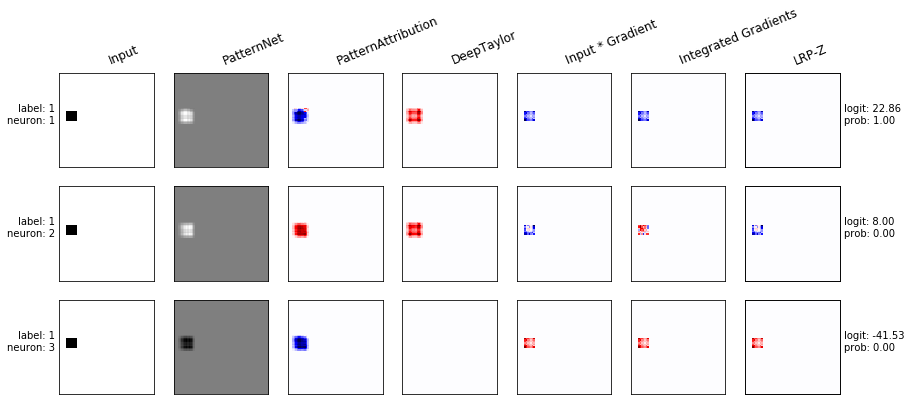

--------------------------------------------------------------------------------
Image nr. 1272; prediction: 3 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

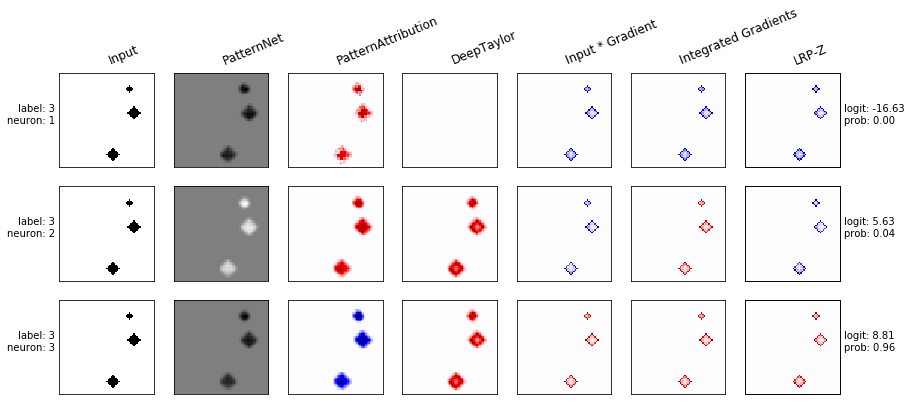

--------------------------------------------------------------------------------
Image nr. 1273; prediction: 2 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

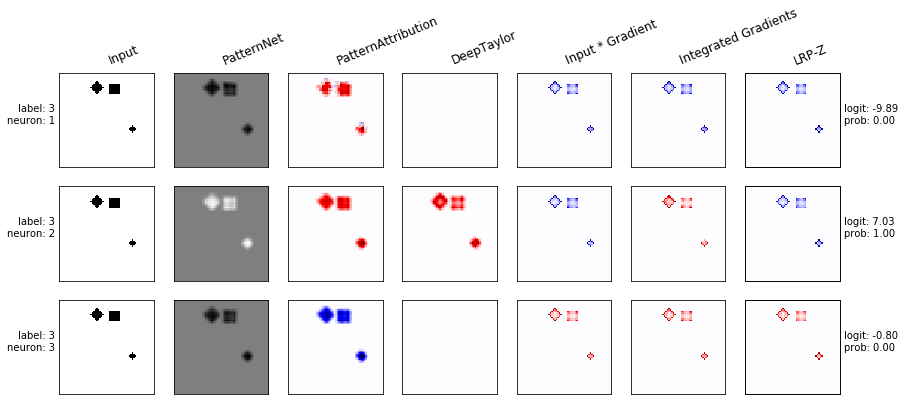

--------------------------------------------------------------------------------
Image nr. 1274; prediction: 3 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

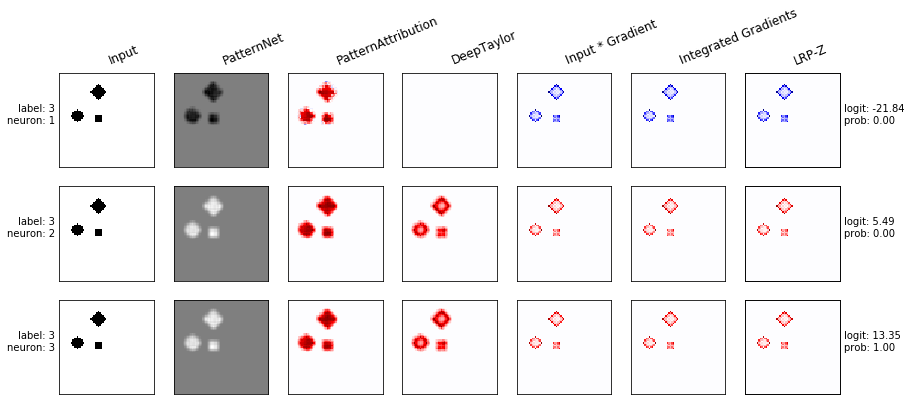

--------------------------------------------------------------------------------
Image nr. 1275; prediction: 1 
('1', '1', '1')


<Figure size 432x288 with 0 Axes>

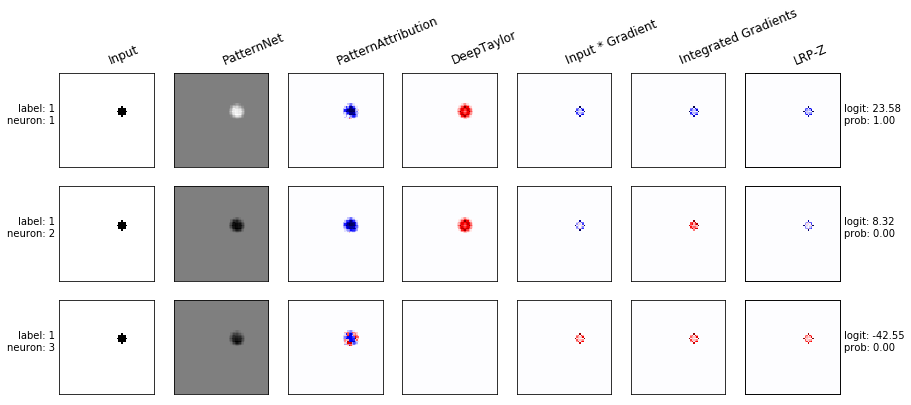

--------------------------------------------------------------------------------
Image nr. 1276; prediction: 2 
('2', '2', '2')


<Figure size 432x288 with 0 Axes>

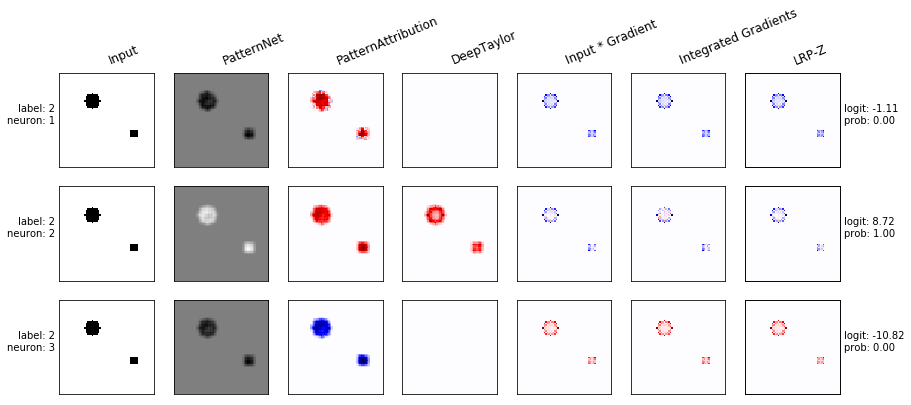

--------------------------------------------------------------------------------
Image nr. 1277; prediction: 2 
('2', '2', '2')


<Figure size 432x288 with 0 Axes>

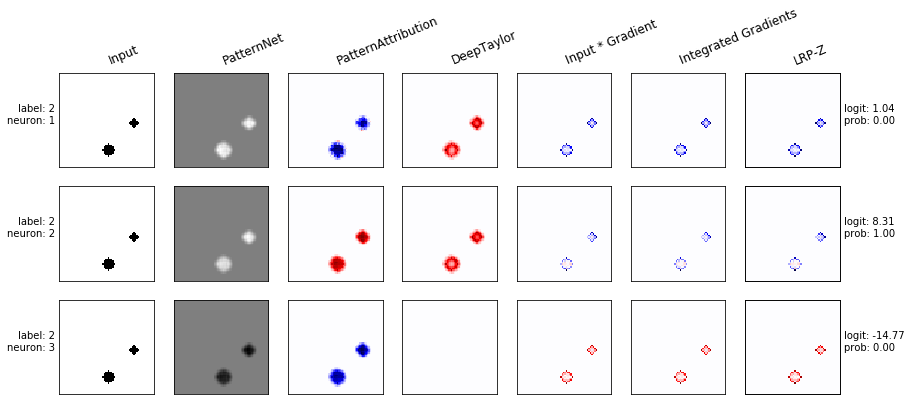

--------------------------------------------------------------------------------
Image nr. 1278; prediction: 2 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

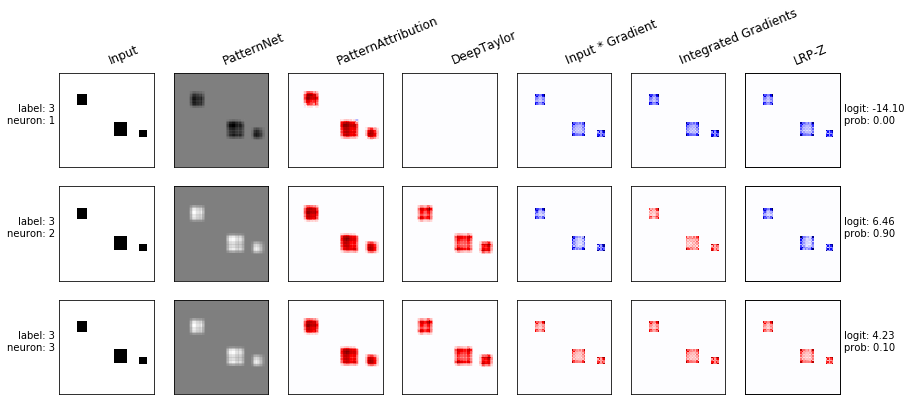

--------------------------------------------------------------------------------
Image nr. 1279; prediction: 3 
('2', '2', '2')


<Figure size 432x288 with 0 Axes>

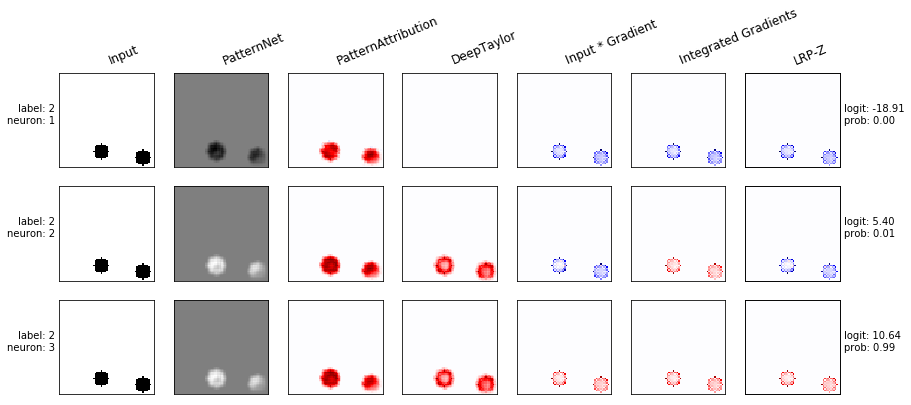

--------------------------------------------------------------------------------
Image nr. 1280; prediction: 1 
('1', '1', '1')


<Figure size 432x288 with 0 Axes>

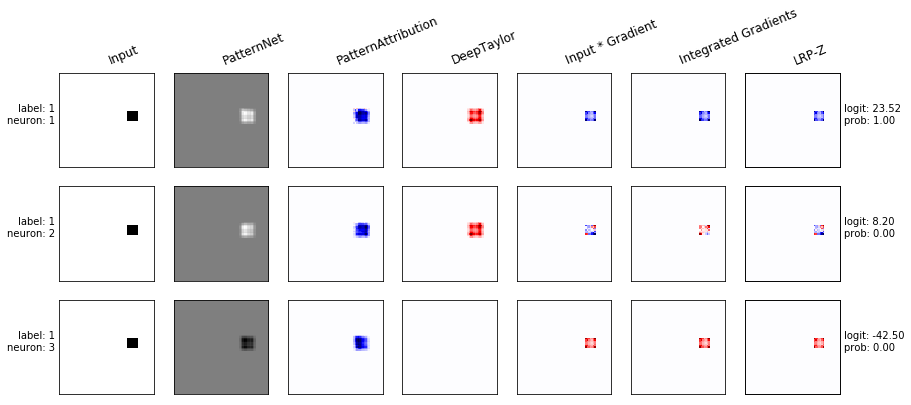

--------------------------------------------------------------------------------
Image nr. 1281; prediction: 2 
('2', '2', '2')


<Figure size 432x288 with 0 Axes>

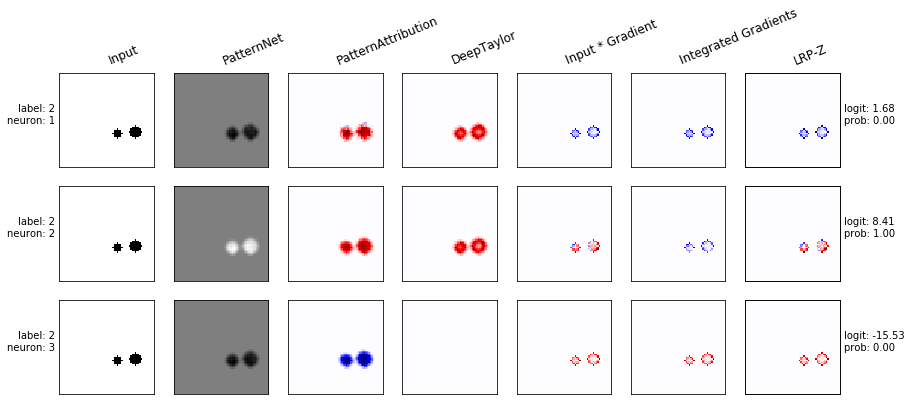

--------------------------------------------------------------------------------
Image nr. 1282; prediction: 2 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

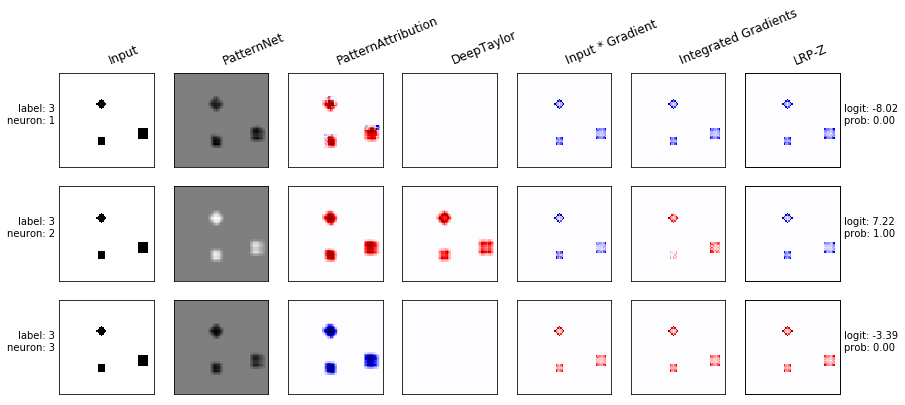

--------------------------------------------------------------------------------
Image nr. 1283; prediction: 2 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

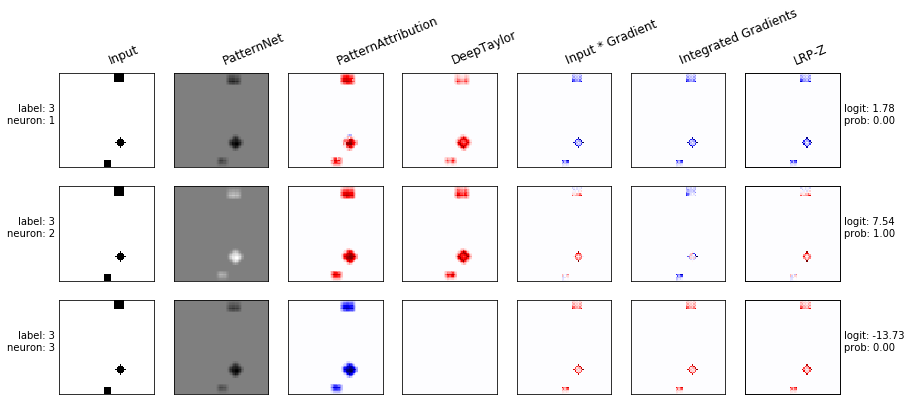

--------------------------------------------------------------------------------
Image nr. 1284; prediction: 1 
('1', '1', '1')


<Figure size 432x288 with 0 Axes>

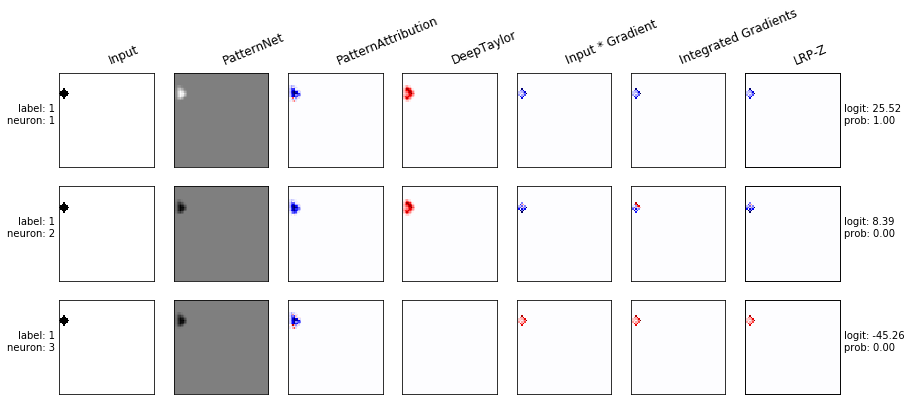

--------------------------------------------------------------------------------
Image nr. 1285; prediction: 3 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

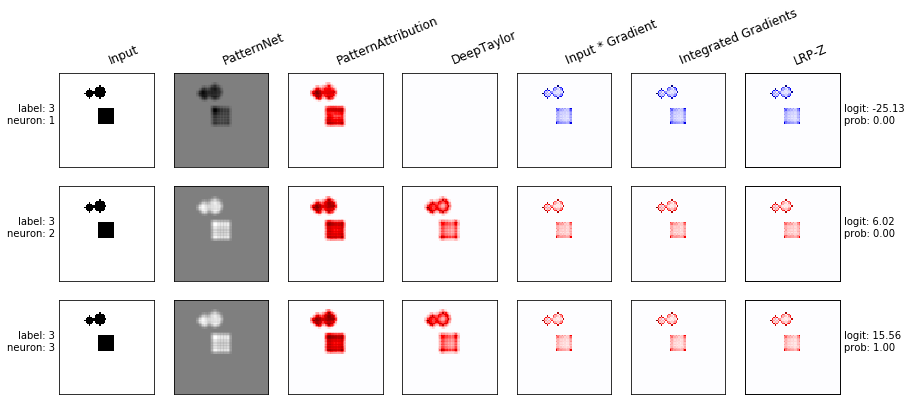

--------------------------------------------------------------------------------
Image nr. 1286; prediction: 3 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

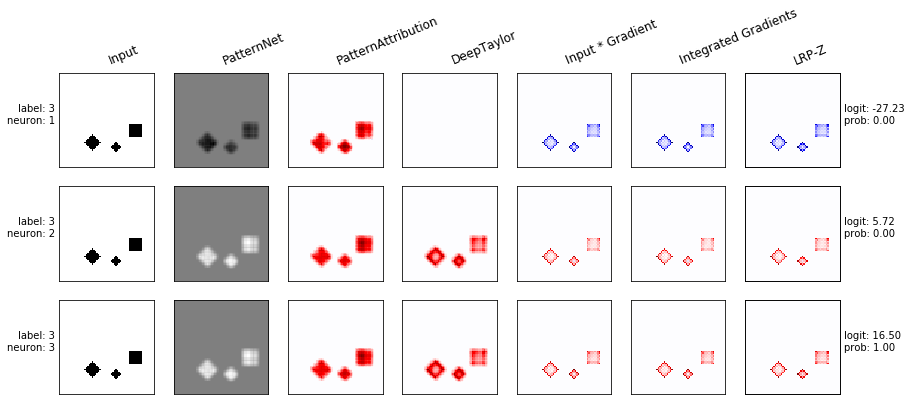

--------------------------------------------------------------------------------
Image nr. 1287; prediction: 1 
('1', '1', '1')


<Figure size 432x288 with 0 Axes>

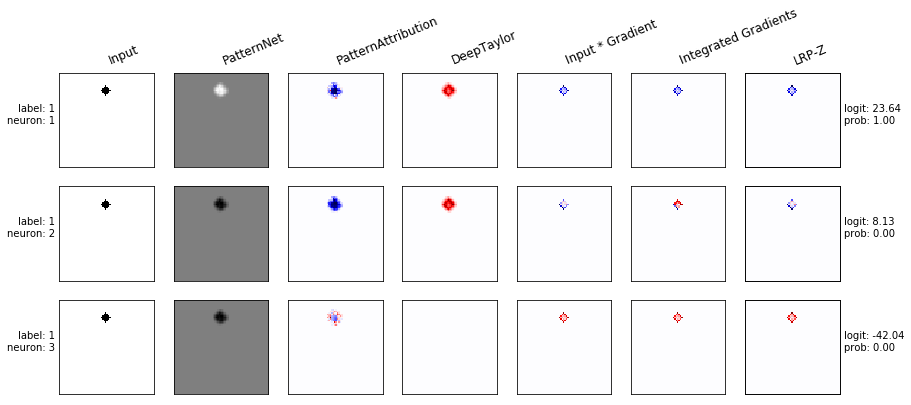

--------------------------------------------------------------------------------
Image nr. 1288; prediction: 2 
('2', '2', '2')


<Figure size 432x288 with 0 Axes>

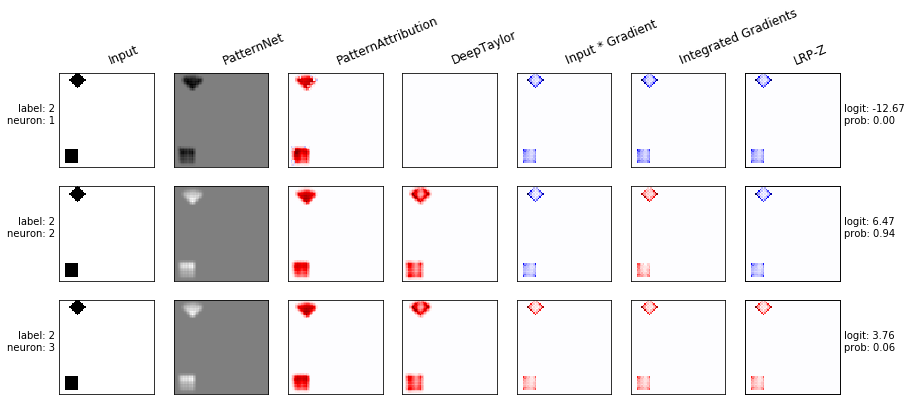

--------------------------------------------------------------------------------
Image nr. 1289; prediction: 2 
('2', '2', '2')


<Figure size 432x288 with 0 Axes>

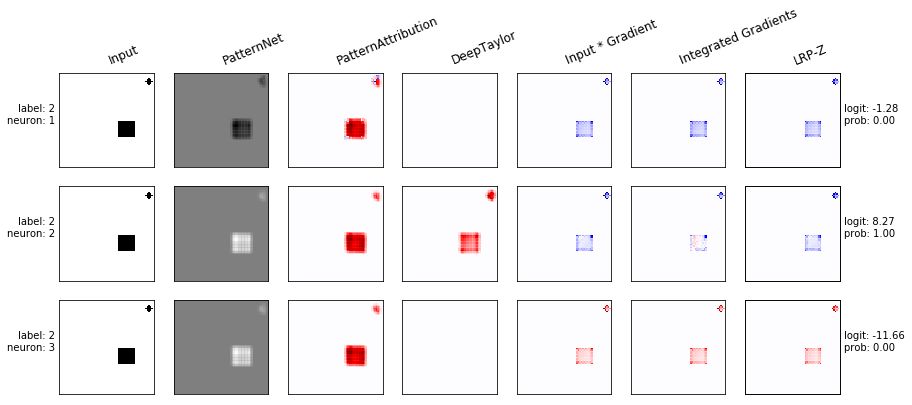

--------------------------------------------------------------------------------
Image nr. 1290; prediction: 1 
('2', '2', '2')


<Figure size 432x288 with 0 Axes>

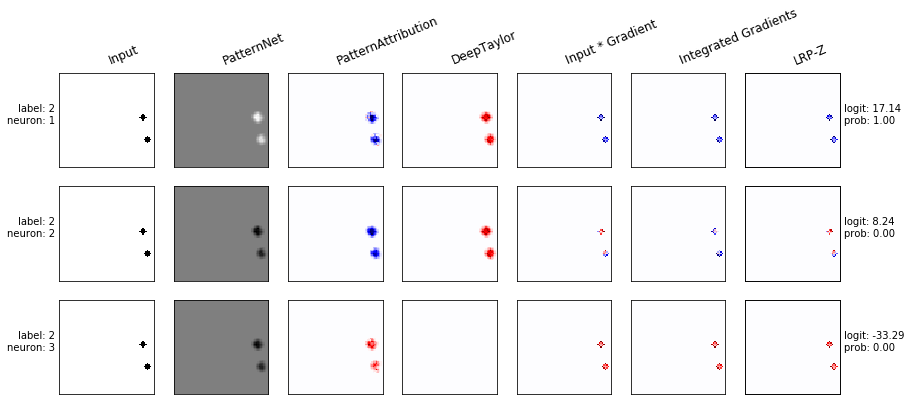

--------------------------------------------------------------------------------
Image nr. 1291; prediction: 2 
('2', '2', '2')


<Figure size 432x288 with 0 Axes>

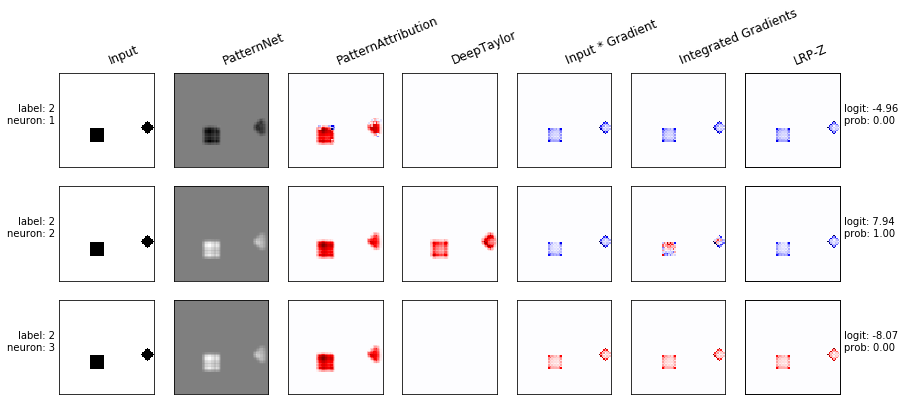

--------------------------------------------------------------------------------
Image nr. 1292; prediction: 3 
('3', '3', '3')


<Figure size 432x288 with 0 Axes>

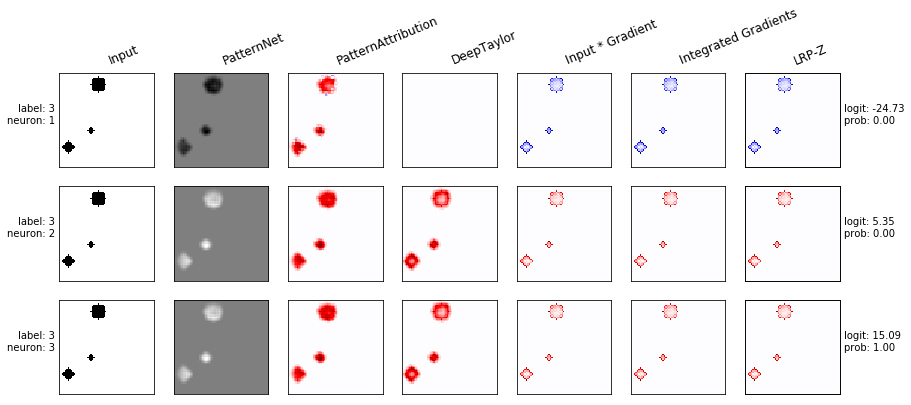

--------------------------------------------------------------------------------
Image nr. 1293; prediction: 2 
('2', '2', '2')


<Figure size 432x288 with 0 Axes>

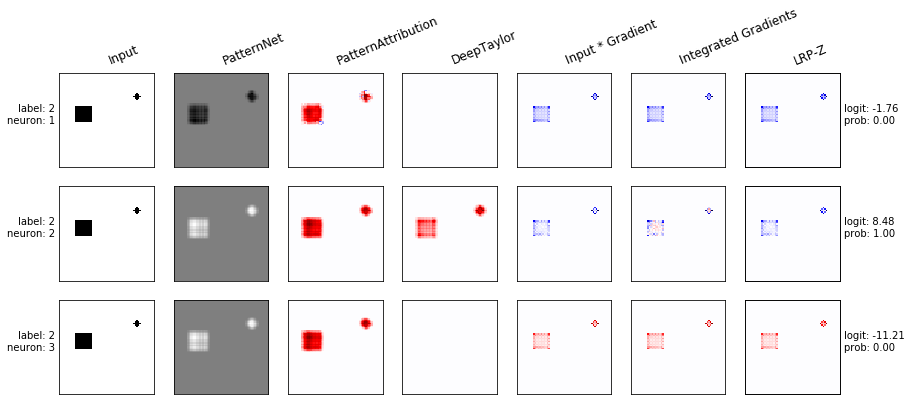

In [9]:
nim = len(labels_test)
ntim = 25
ind = int(np.random.randint(1,nim-ntim))

test_images = list(zip(images_test[ind:ind+ntim], numerical_labels_test[ind:ind+ntim]-1))
label_to_class_name = [str(i+1) for i in range(num_classes)]

for image_nr, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]

    analysis = np.zeros([num_classes, len(analyzers), 64, 64, 3])
    text = []

    for ii, output_neuron in enumerate([0, 1, 2]):
        # Predict final activations, probabilites, and label.
        presm = model_wo_softmax.predict_on_batch(x)[0]
        prob = model.predict_on_batch(x)[0]
        y_hat = prob.argmax()

        # Save prediction info:
        text.append(("%s" % label_to_class_name[y],    # ground truth label
                     "%.2f" % presm[output_neuron],    # pre-softmax logits
                     "%.2f" % prob[output_neuron],     # probabilistic softmax output  
                     "%s" % label_to_class_name[output_neuron]
                    ))
       

        for aidx, analyzer in enumerate(analyzers):
            # Analyze.
            a = analyzer.analyze(x, neuron_selection=output_neuron)

            # Apply common postprocessing, e.g., re-ordering the channels for plotting.
            a = mnistutils.postprocess(a)
            # Apply analysis postprocessing, e.g., creating a heatmap.
            a = methods[aidx][2](a)
            # Store the analysis.
            analysis[ii, aidx] = a[0]

    print("-"*80)
    print("Image nr. {}; prediction: {} ".format(ind+image_nr, y_hat+1))
    # Prepare the grid as rectengular list
    grid = [[analysis[i, j] for j in range(analysis.shape[1])]
            for i in range(analysis.shape[0])]
    # Prepare the labels
    label, presm, prob, pred = zip(*text)
    print(label)
    row_labels_left = [('label: {}'.format(label[i]), 'neuron: {}'.format(pred[i])) for i in range(len(label))]
    row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
    col_labels = [''.join(method[3]) for method in methods]

    # Plot the analysis.
    file_name = os.environ.get("PLOTFILENAME", None)
    if file_name is not None:
        file_name = ".".join(file_name.split(".")[:-1])+("_%i" % output_neuron)+file_name.split(".")[-1]   
    n_rows = len(grid)
    n_cols = len(grid[0])
    figsize = (2*n_cols, 2*(n_rows+1))
    eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels, figsize=figsize, file_name=file_name)
